<center><h1 style="font-size:40px;">Project 1<br> Recurrent Neural Networks
</h1></center>

---

This project will develop an **Recurrent neural network (RNN)**. The task is to predict the next image in a series.

The task provide a dataset which creates a series of images where the last image in the series is the target. 

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

Good luck!

---

# Task

**TODO:** Implement **RNN** to predict the next image in the series. 

**TODO:** Select a good metric to evaluate the models performance and argue why the metric give a good overview of the performance.

**Question:** Explain in the report what you did and why. Present a pipeline of the code. 

--- 

**Note:** The current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT) in config.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** As a generator model, you can use the segmentation model implemented in lab03. Do not forget to adapt the input and output shapes of the generator model in this case.




# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
from config import LabConfig
import torchmetrics
import transforms as T
import torchvision
from torch.utils.data import DataLoader
from utils.dataset import FutureFramePredictorDataset
from utils.plot import RNN
from utils.model import Model
import pytorch_lightning as pl
%matplotlib inline
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.model import Model
from utils.progressbar import LitProgressBar
from utils import plot
from torch.autograd import Variable
import io
import imageio
from ipywidgets import widgets, HBox

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load config
Note that this lab does not support for fineGrained dataset.

In [4]:
cfg = LabConfig()
cfg.todict()

{'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEQUENCE_LENGTH': 5,
 'NUM_CLASSES': 3,
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

In [5]:
cfg.BATCH_SIZE = 2
cfg.IMAGE_HEIGHT = 128
cfg.IMAGE_WIDTH = 128
cfg.todict()

{'BATCH_SIZE': 2,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEQUENCE_LENGTH': 5,
 'NUM_CLASSES': 3,
 'SEED': 420,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'TENSORBORD_DIR': 'logs/'}

# Dataset
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at [pytorch docs](https://pytorch.org/vision/stable/transforms.html)

The Artificial Flying Objects Dataset consist of a series of images where the last image in the series are the target image. All other images use the target image for the prediction. 

The dataset with images moving through a sequence.
- 128x128x3 
- Around 30 frames in each sequence, 
- In total 10K data for training, 2K for validation and 2K for testing

![Example Gif](../../data/images/ArtificialFlyingObjects.gif)


Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader. For semantic segmentation we do not only have an input image $x$ but also an target label $y$. If we apply example: *RandomHorizontalFlip* the expected target image will be observed but will not be same rotation.

**Hint:** To ensure that the CNN take the images as a sequence the images are concatenated along the channel dimension. The input shape will look like: $(batch\_size*sequence\_length, C, H, W)$. Also, test: $x.view(batch\_size, sequence\_length, -1)$ to process the images in a sequence after CNN.

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [6]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST),
    T.RandomHorizontalFlip(0.5)
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
])

## Dataloader

In [7]:
train_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.training_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=train_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS

)

valid_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.validation_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

test_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.testing_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we will first plot the data. This is very important, especially if we perform data augmentation. If the implementation is wrong an qualitative estimation will with a great probability tell if something is wrong.

In [8]:
t_x, t_y = next(iter(train_dataloader))

In [9]:
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")

x (2, 15, 128, 128) torch.float64 0.0 1.0
y (2, 15, 128, 128) torch.float64 0.0 1.0


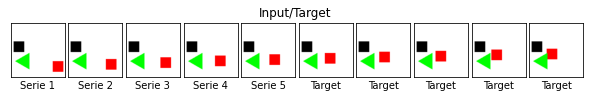

In [10]:
RNN.data(t_x, t_y, cfg.SEQUENCE_LENGTH, nrows=1, title_size=2)

# Implementation

---

In [11]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, frame_size):

        super(ConvLSTMCell, self).__init__()  

        self.activation = torch.tanh
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.zeros(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.zeros(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.zeros(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [12]:
class ConvLSTM(nn.Module):
#Idea from https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582 
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, frame_size)

    def forward(self, X):
        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)
        # Technically (batch_size, num_channels*seq_len, height, width) 
        # but it's seperated to the former dimensions with view in Seq2Seq
        
        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):
            # Send each time step into convLSTM cells
            H, C = self.convLSTMcell(X[:,:,time_step], H, C)
            output[:,:,time_step] = H
        return output

In [13]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, frame_size):

        super(Seq2Seq, self).__init__()
        self.frame_size = frame_size
        # Add First layer (Different in_channels than the rest)
        self.sequential = nn.Sequential()
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        )
        
        self.sequential2 = nn.Sequential()
        self.sequential2.add_module(
            "convlstm2", ConvLSTM(
                in_channels=num_kernels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        )
        self.sequential2.add_module(
            "batchnorm2", nn.BatchNorm3d(num_features=num_kernels)
        )        
        #Add Convolutional 2D Layer to predict output frame, takes
        #the hidden state at the last time step of the last layer and predicts a frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding, device=device)

    def forward(self, X):
        h, w = self.frame_size       
        batch = X.size(0) 
        X = X.view(batch, 3, 5, h, w).float()      
        outputs = torch.zeros(batch, 3, 5, h, w)
        #generating the 5 future frames
        for frame in range(5):
            output = self.sequential(X)
            output = self.sequential2(output)
            output = self.conv(output[:, :, -1])
            X = torch.cat([X, output[:, :, None]], dim=2)
            outputs[:, :, frame] = output    
        outputs=outputs.view(batch, -1, h, w)
        #pass through sigmoid function to get pixel values between 0 and 1
        return nn.Sigmoid()(outputs.double().to(device))

In [14]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":1e-4,
            "weight_decay":0.0005
        }
    },
    'criterion':torch.nn.MSELoss(), # error function
    'max_epochs':50,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

In [15]:
 torch.cuda.empty_cache()

In [16]:
framesize=(cfg.IMAGE_WIDTH, cfg.IMAGE_HEIGHT)
modelObj = Model(Seq2Seq(num_channels=3, num_kernels=30, kernel_size=(3,3), padding=(1,1),
                          frame_size=framesize), **config)
modelObj.to(device)
#modelObj = model.cuda()

Model(
  (model): Seq2Seq(
    (sequential): Sequential(
      (convlstm1): ConvLSTM(
        (convLSTMcell): ConvLSTMCell(
          (conv): Conv2d(33, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (batchnorm1): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (sequential2): Sequential(
      (convlstm2): ConvLSTM(
        (convLSTMcell): ConvLSTMCell(
          (conv): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (batchnorm2): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv): Conv2d(30, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (criterion): MSELoss()
  (train_metrics): MetricCollection(
    (Accuracy): Accuracy(),
    postfix=_Train
  )
  (validation_metrics): MetricCollection(
    (Accuracy): Accuracy(),
    postfix=_Validation
  )
)

In [17]:
# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary='full', # Can be None, top or full
            num_sanity_val_steps=10,   
        )

# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
    
);


C:\Users\John\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
C:\Users\John\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:187: LightningDeprecationWarning: Setting `Trainer(weights_summary=full)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.model_summary.ModelSummary` with `max_depth` directly to the Trainer's `callbacks` argument instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\John\a

C:\Users\John\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1805: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(


In [18]:
# Plotting

In [19]:
trainer.test(test_dataloaders = test_dataloader)

C:\Users\John\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:899: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
C:\Users\John\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1391: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/default\version_338\checkpoints\epoch=49-step=23649.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/default\version_338\checkpoints\epoch=49-step=23649.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_Test': 0.4865582585334778}
--------------------------------------------------------------------------------


[{'loss_Test': 0.4865582585334778}]

In [20]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    2459 MB |  565073 GB |  565073 GB |
|       from large pool |       0 B  |    2457 MB |  561987 GB |  561987 GB |
|       from small pool |       0 B  |       4 MB |    3086 GB |    3086 GB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    2459 MB |  565073 GB |  565073 GB |
|       from large pool |       0 B  |    2457 MB |  561987 GB |

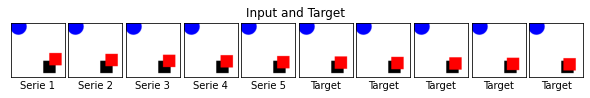

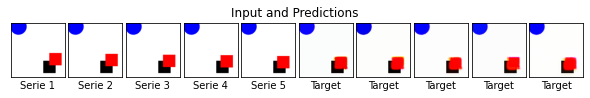

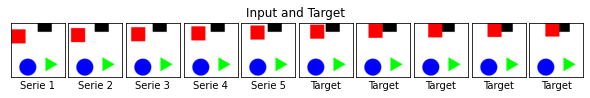

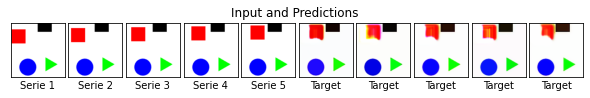

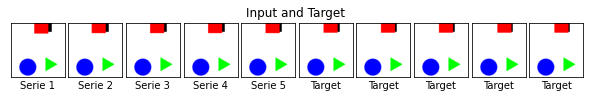

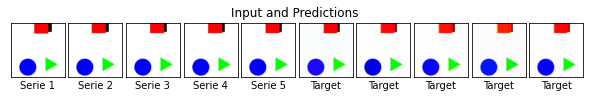

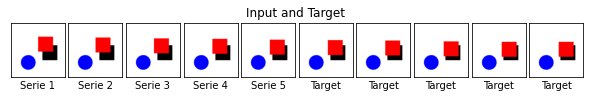

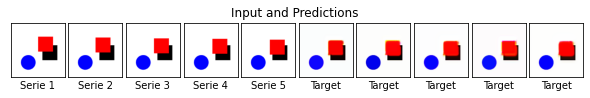

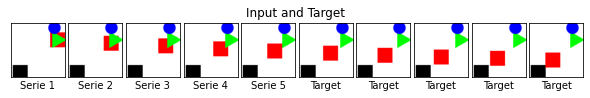

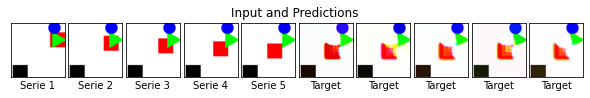

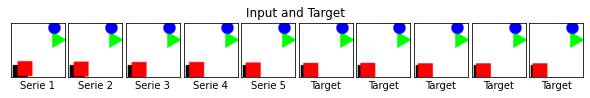

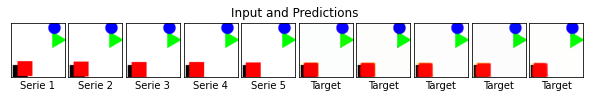

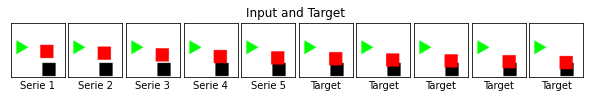

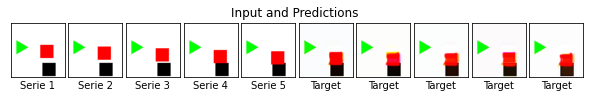

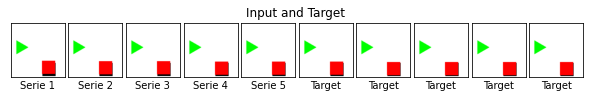

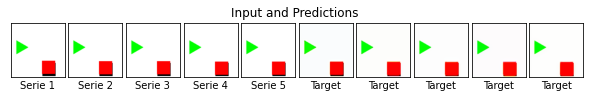

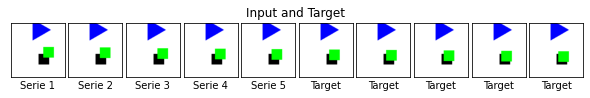

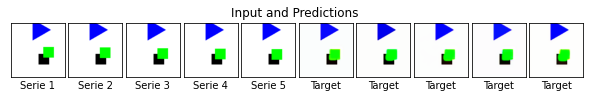

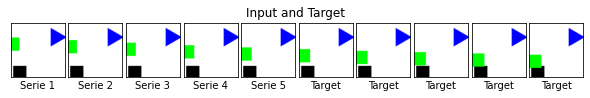

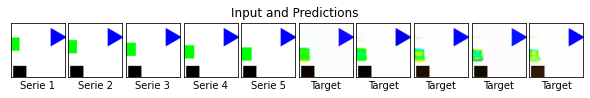

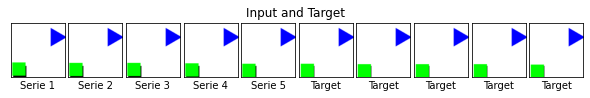

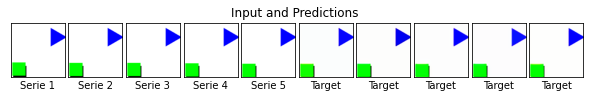

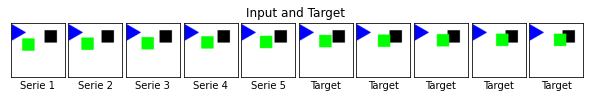

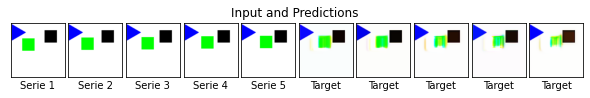

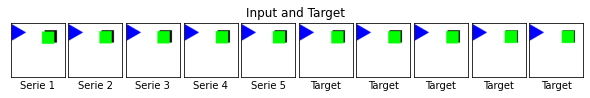

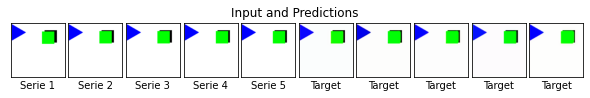

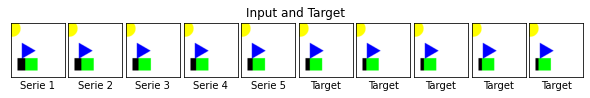

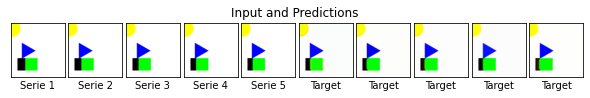

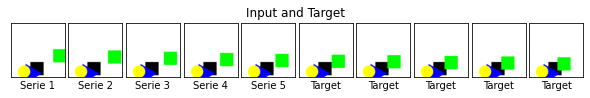

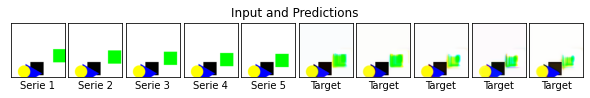

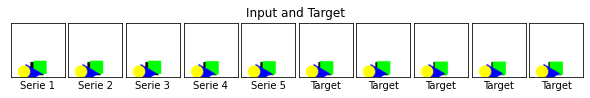

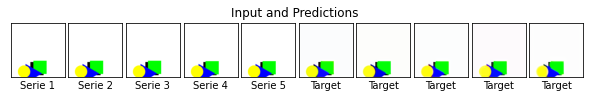

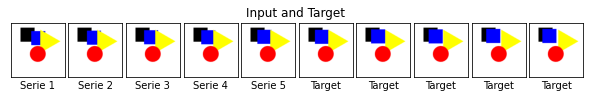

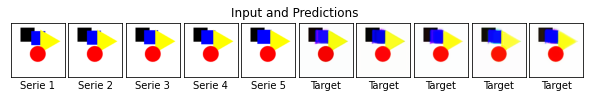

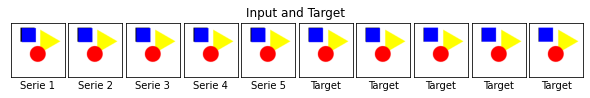

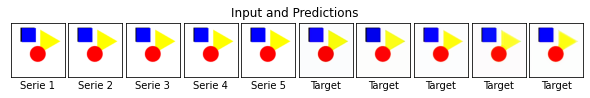

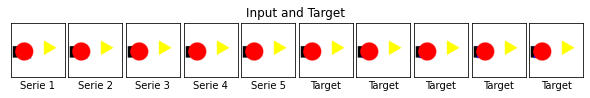

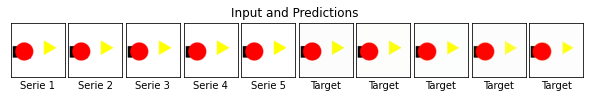

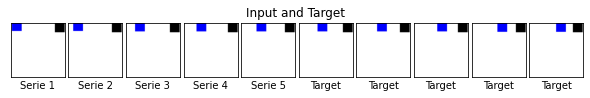

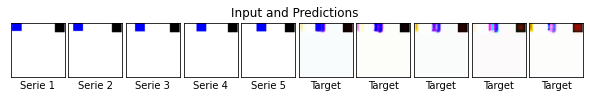

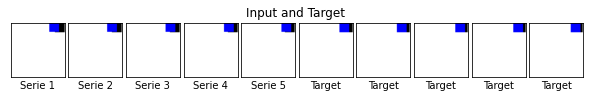

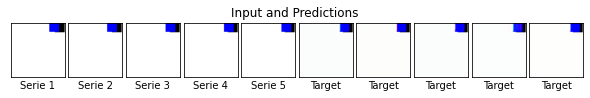

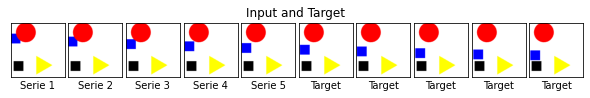

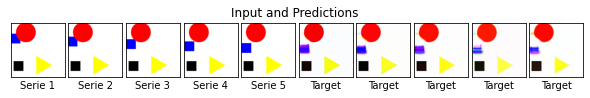

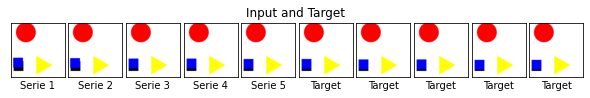

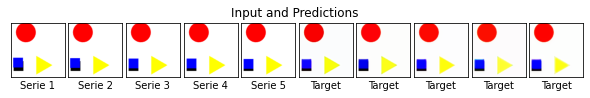

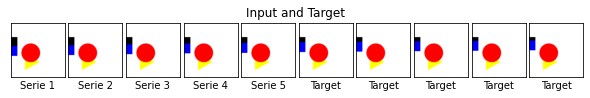

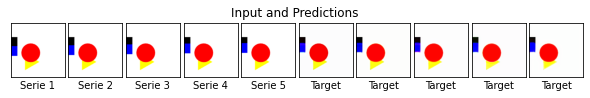

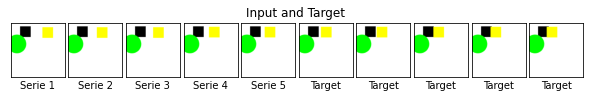

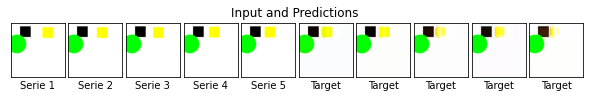

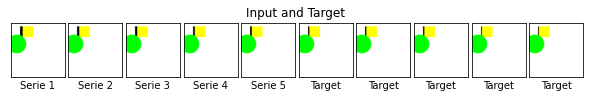

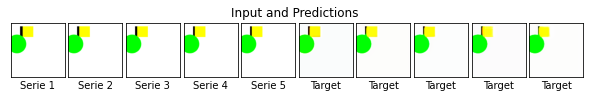

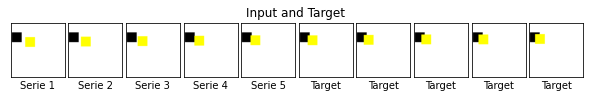

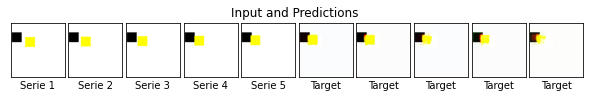

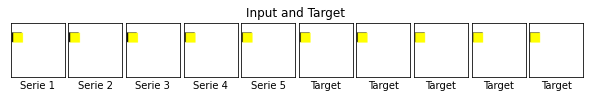

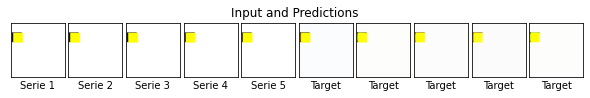

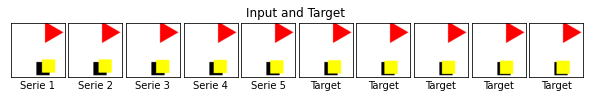

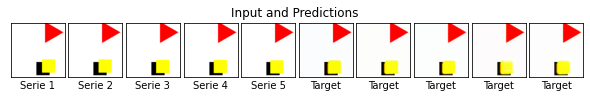

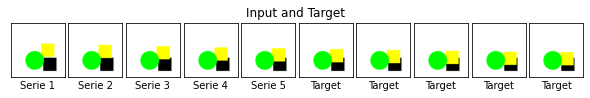

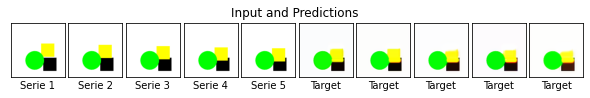

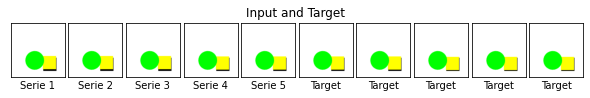

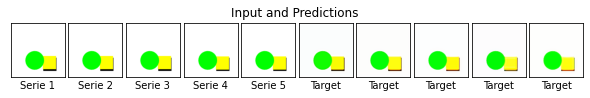

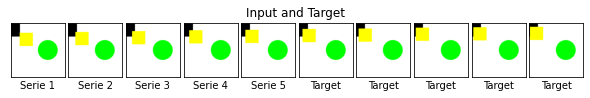

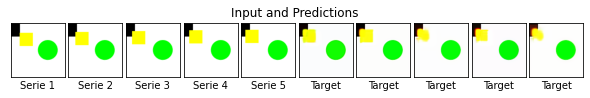

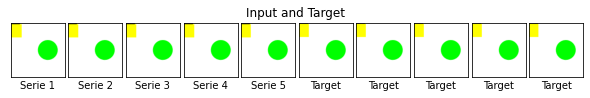

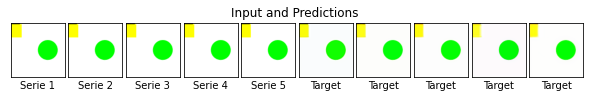

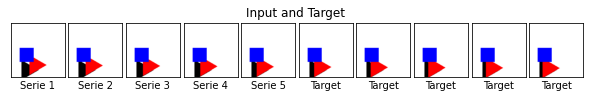

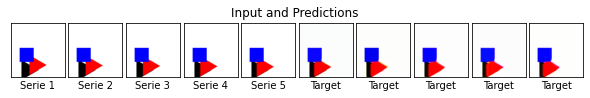

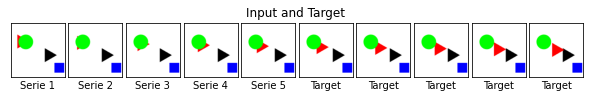

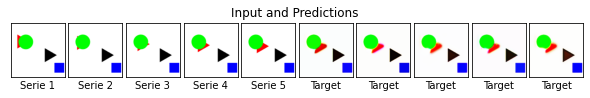

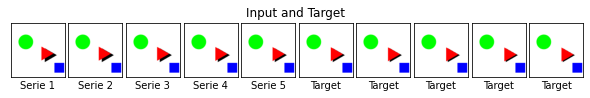

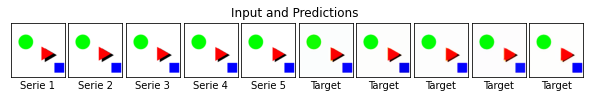

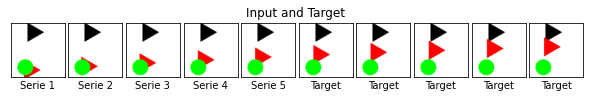

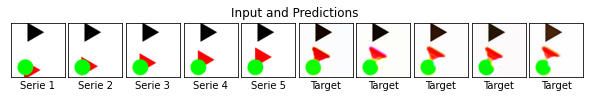

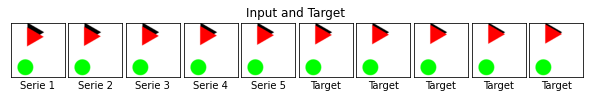

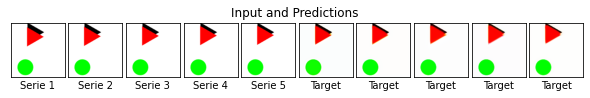

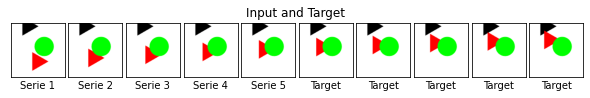

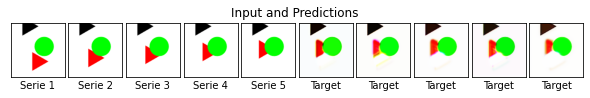

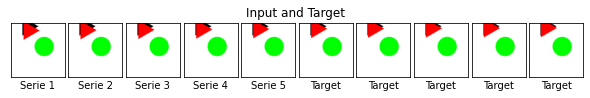

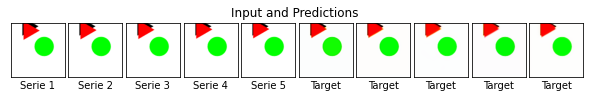

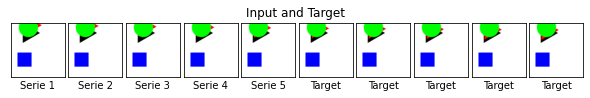

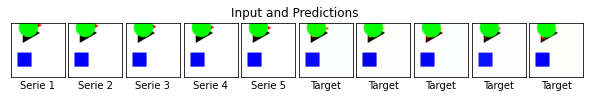

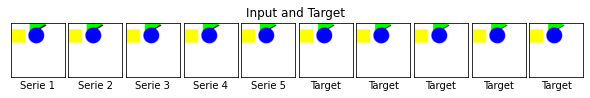

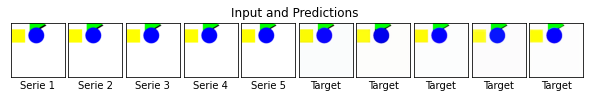

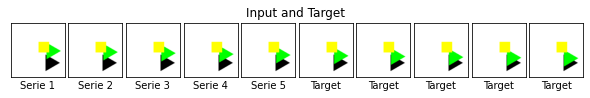

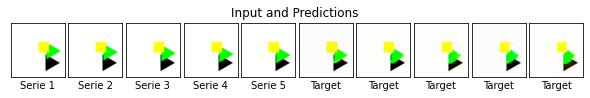

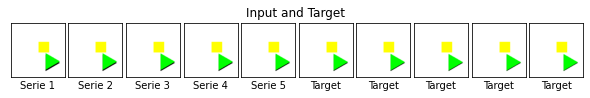

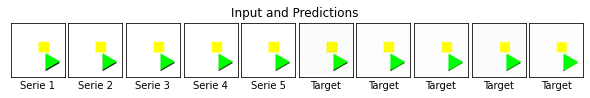

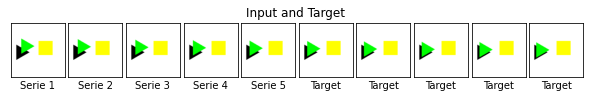

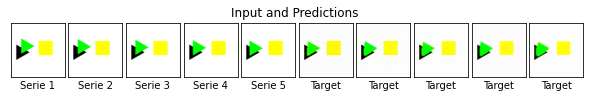

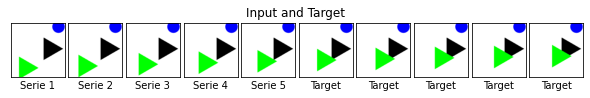

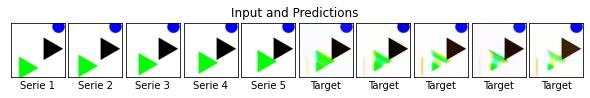

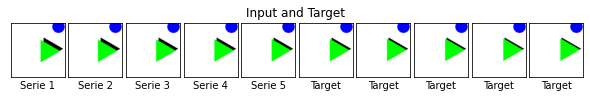

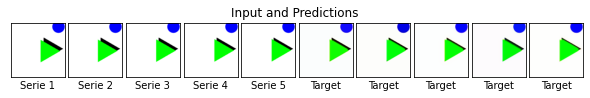

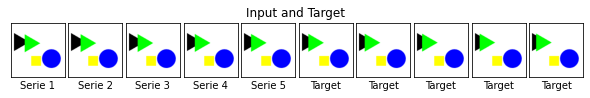

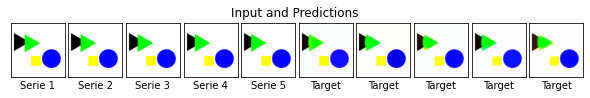

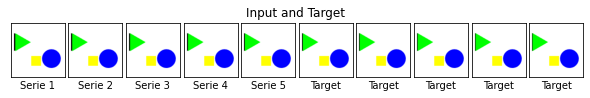

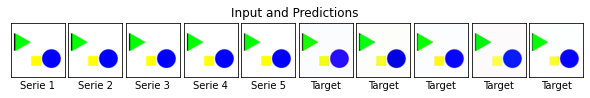

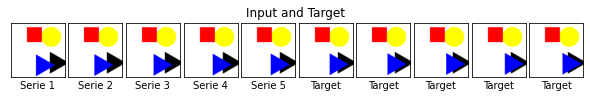

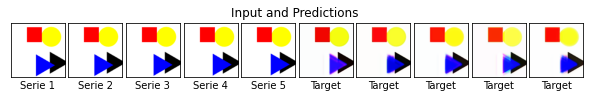

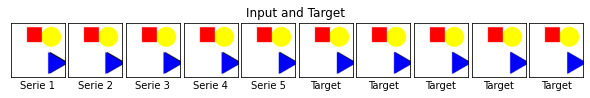

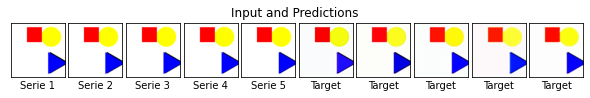

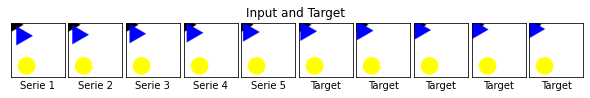

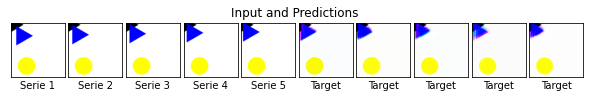

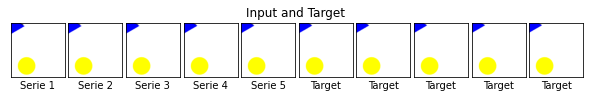

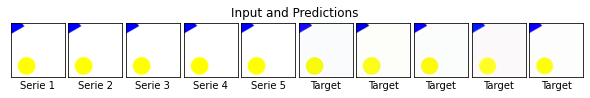

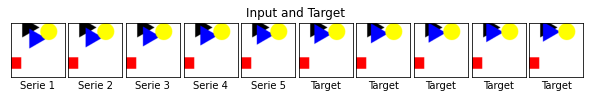

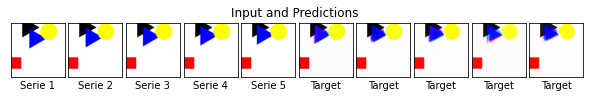

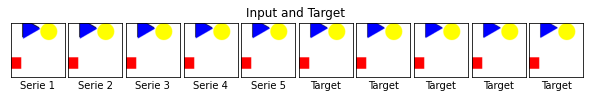

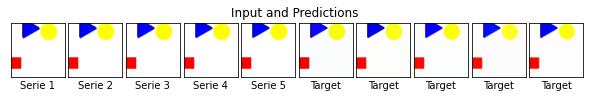

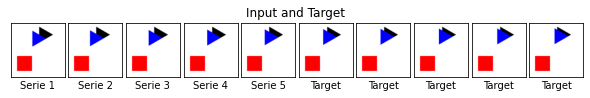

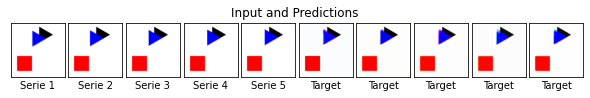

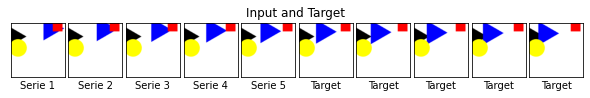

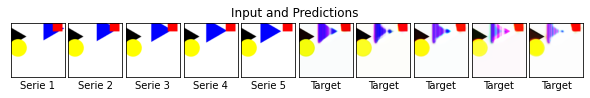

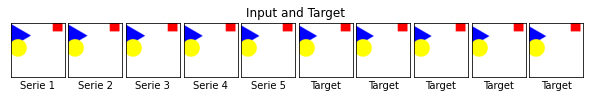

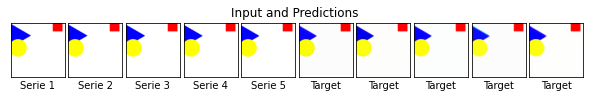

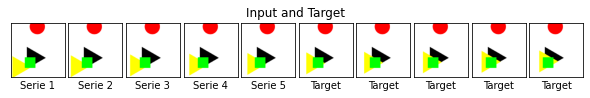

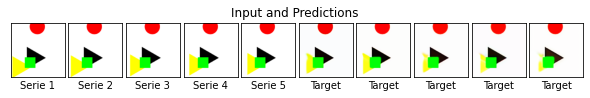

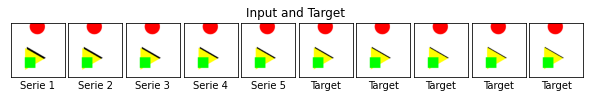

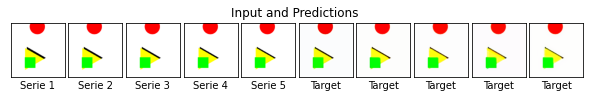

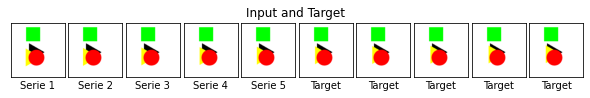

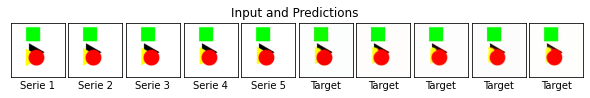

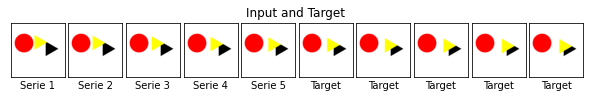

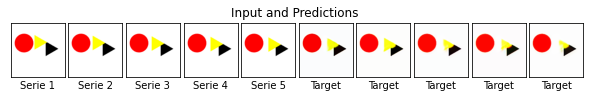

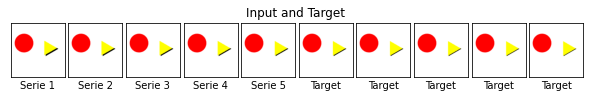

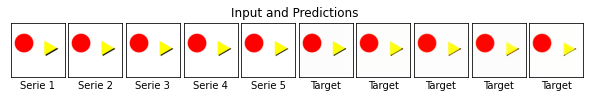

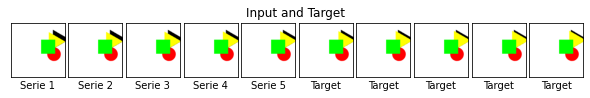

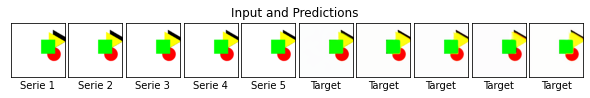

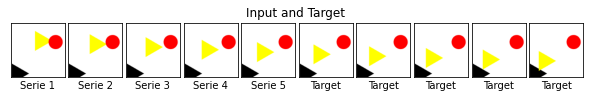

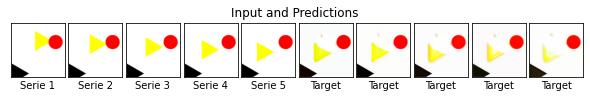

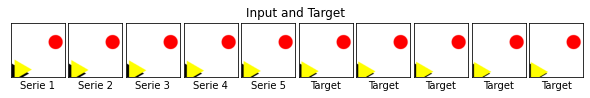

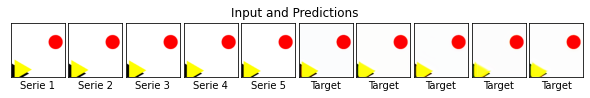

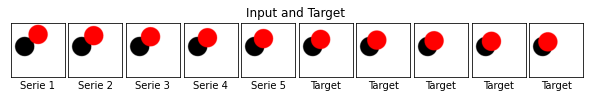

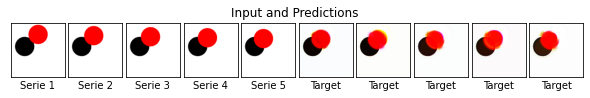

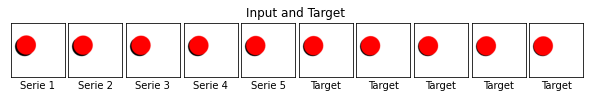

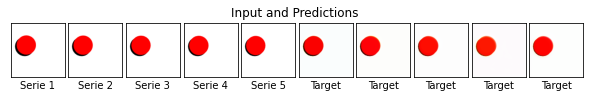

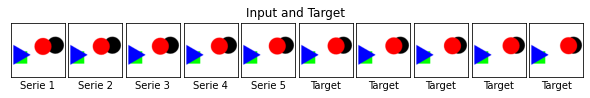

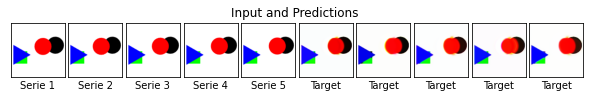

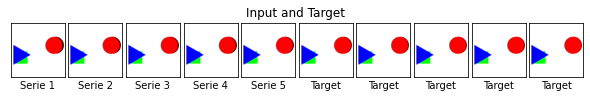

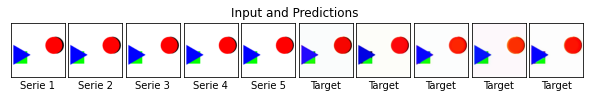

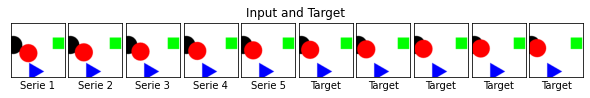

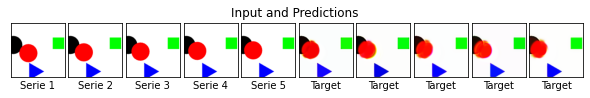

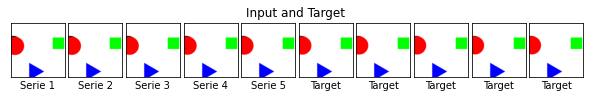

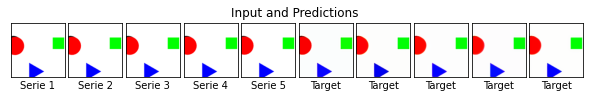

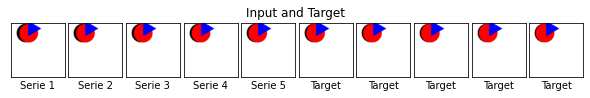

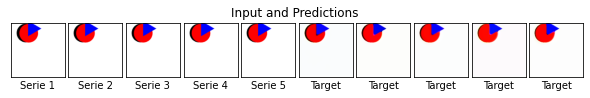

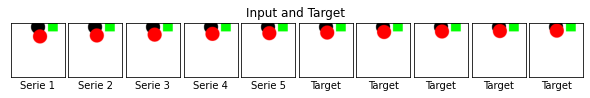

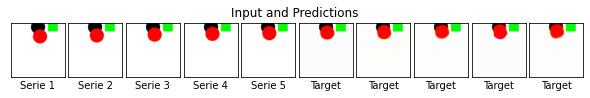

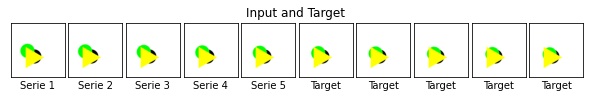

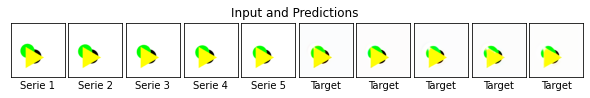

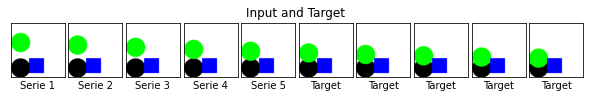

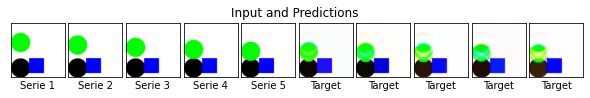

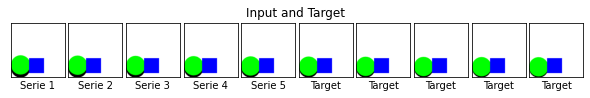

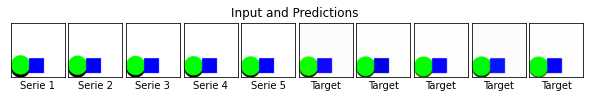

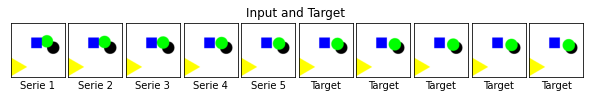

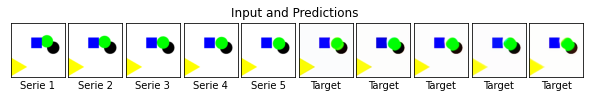

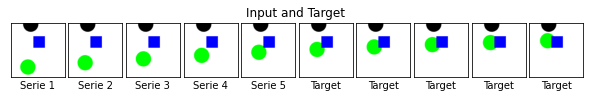

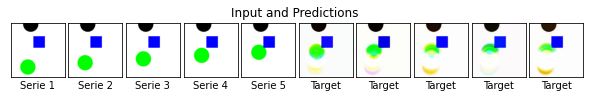

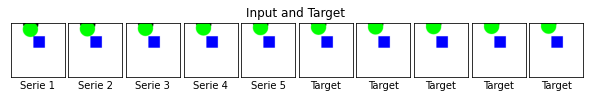

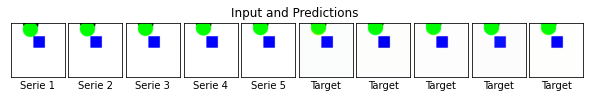

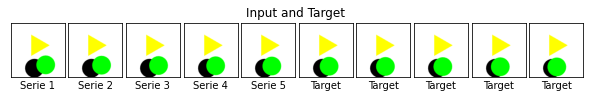

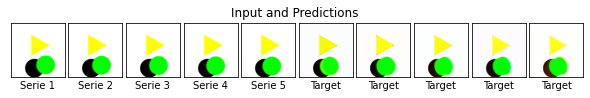

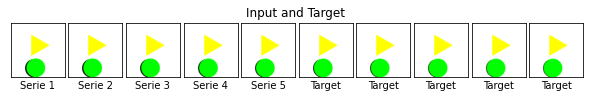

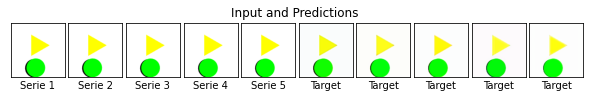

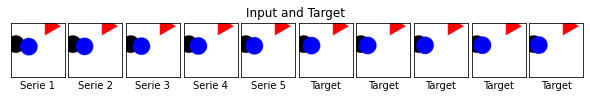

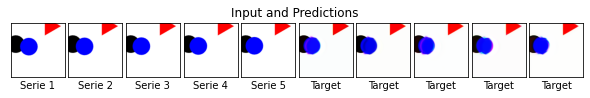

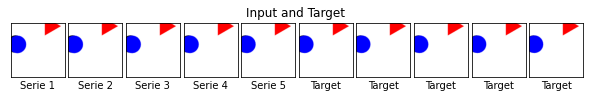

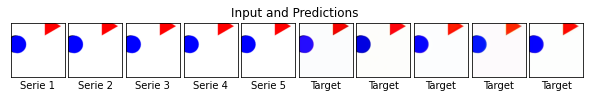

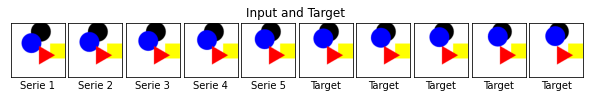

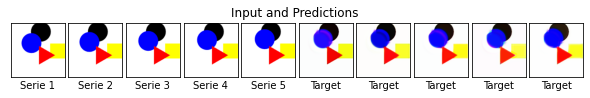

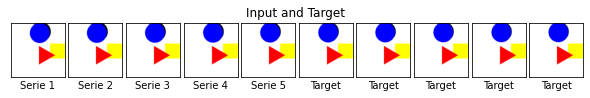

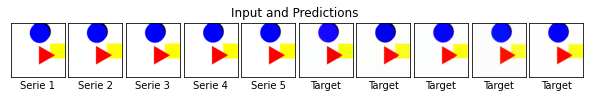

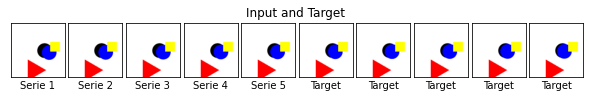

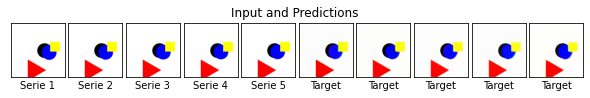

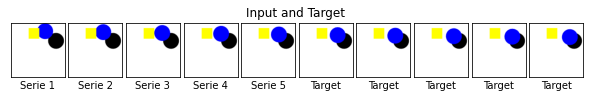

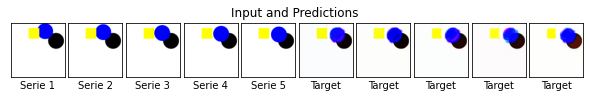

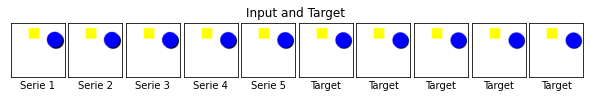

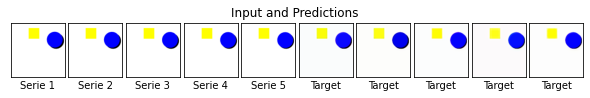

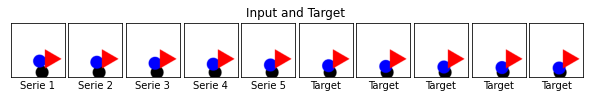

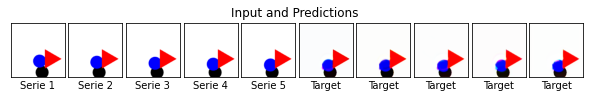

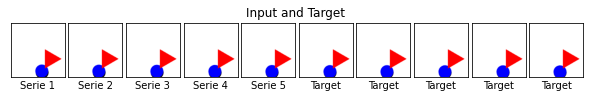

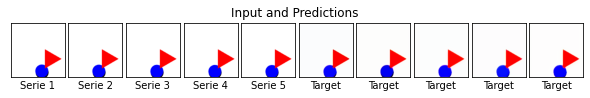

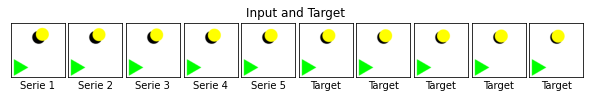

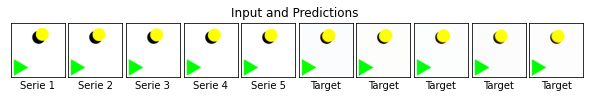

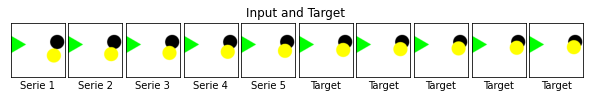

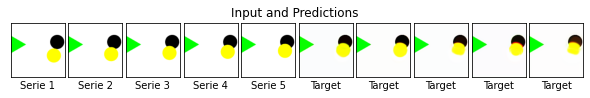

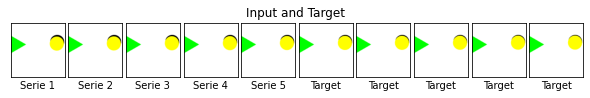

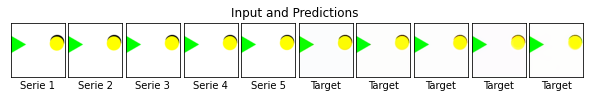

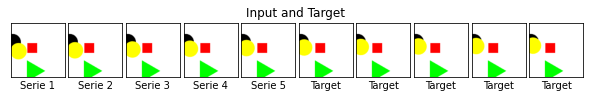

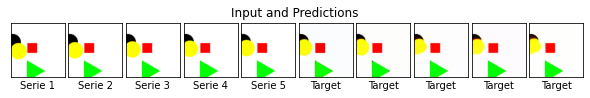

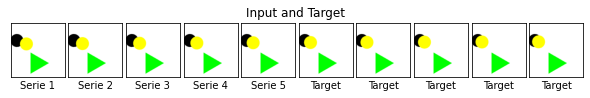

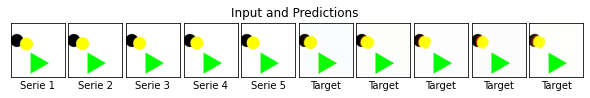

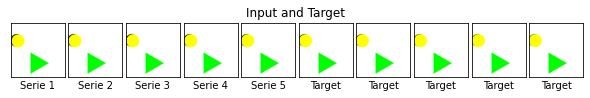

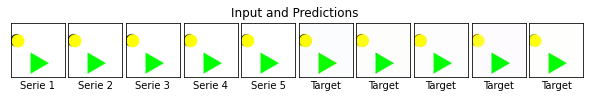

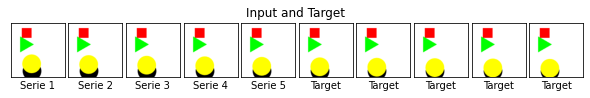

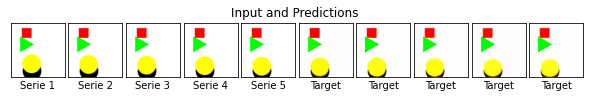

In [21]:
modelObj.to(device)
for x, y in iter(test_dataloader):
    x, y = x.to(device), y.to(device)
    preds = modelObj(x)
    RNN.data(x.cpu(), y.cpu(), cfg.SEQUENCE_LENGTH, nrows=1, title="Input and Target")
    RNN.data(x.cpu(), preds.detach().cpu(), cfg.SEQUENCE_LENGTH, nrows=1, title="Input and Predictions")